In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
with open('3.txt', 'rt') as f:
    output = f.read().splitlines()
output = output[1:]
def rd():
    global output
    n = int(output[0])
    output = output[1:]
    d = [[float(a) for a in l.split()] for l in output[:n]]
    yi = np.array([x[-1] for x in d])
    for x in d:
        x[-1] = 1
    xi = np.mat(d)
    output = output[n:]
    return (n, xi, yi)
# (ntrain, trainX, trainY) = rd()
# (ntest, testX, testY) = rd()
(ntest, testX, testY) = rd()
(ntrain, trainX, trainY) = rd()
assert output == []
assert(len(testY) <= len(trainY))

если не привести числа к более маленьким то
* появляются переполнения
* $\hat{y}$ становится сильно меньше чем $y$ и SMAPE остается около 2 всегда

In [3]:
mx = np.max(abs(trainX)) / 100
trainX /= mx
trainY /= mx
testX /= mx
testY /= mx

In [4]:
def normal(x):
    l = np.linalg.norm(x)
    if l == 0:
        return np.zeros(x.shape)
    return x / l
def flattify(x):
    return np.squeeze(np.asarray(x.transpose()))

In [5]:
def MSE(x, y, p, reg):
    y1 = flattify(x @ p)
    return np.mean((y - y1) ** 2) + bonus(p, reg)
def NRMSE(x, y, p, reg):
    return np.sqrt(MSE(x, y, p, reg)) / (np.max(y) - np.min(y))
def SMAPE(x, y, p, reg):
    y1 = flattify(x @ p)
    return np.mean(abs(y - y1) * 2 / (abs(y) + abs(y1))) + bonus(p, reg)

In [6]:
def bonus(w, reg):
    # return 0
    return 0.5 * reg * np.sum(w ** 2)

In [7]:
def least2(x, y, reg):
    (u, s, vt) = np.linalg.svd(x, False)
    res = vt.transpose() @ np.diag(s / (s ** 2 + reg)) @ u.transpose() @ y
    return flattify(res)
def least2Score(x, y, res, reg):
    # return MSE(x, y, res, reg)
    y1 = flattify(x @ res)
    return np.sum((y - y1) ** 2) + bonus(res, reg)

In [8]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [9]:
def objective_least2(trial):
    reg = trial.suggest_float("reg", 0, 100)
    p = least2(trainX, trainY, reg)
    trial.set_user_attr('p', p)
    return least2Score(trainX, trainY, p, reg=reg)
study_least2 = optuna.create_study()
study_least2.optimize(objective_least2, n_trials=100)
print("Best value: {} (params: {})\n".format(study_least2.best_value, study_least2.best_params))
least2Par = study_least2.best_params

Best value: 0.011620595375040123 (params: {'reg': 0.006192708906761116})



MSE


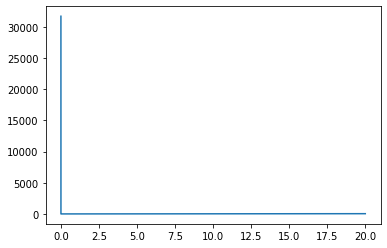

SMAPE


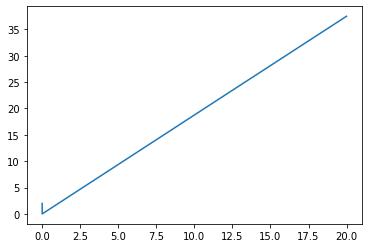

In [28]:
l2x = []
l2yMSE = []
l2ySMAPE = []
for r in range(10000):
    reg = r / 500.0
    res = least2(testX, testY, reg)
    l2x.append(reg)
    l2yMSE.append(MSE(testX, testY, res, reg))
    l2ySMAPE.append(SMAPE(testX, testY, res, reg))

def gr(s, y):
    print(s)
    plt.figure()
    # plt.xscale('log')
    # plt.yscale('log')
    plt.plot(l2x, y)
    plt.show()
gr("MSE", l2yMSE)
gr("SMAPE", l2ySMAPE)

https://towardsdatascience.com/gradient-descent-from-scratch-e8b75fa986cc

стохастический

In [17]:
def mkStart():
    return (np.random.rand(trainX.shape[1]) / 2 - 1) / trainX.shape[1]
START = mkStart()

In [22]:
def gradDes(x, y, f, fgrad, reg=0.01, st=0.98, step=None, start=None, draw=False):
    p = START if start is None else start
    step = step or np.linalg.norm(p)
    reg /= step
    pys = []
    ema = None
    emaC = 0.9
    cnt = 2000
    for _ in range(cnt):
        if draw:
            c = f(x, y, p, reg)
            # print(c)
            if ema is None:
                ema = c
            else:
                ema = emaC * c - (1 - emaC) * ema
            pys.append(ema)
        sel = random.randint(0, x.shape[0]-1)
        g = fgrad(x, y, p, sel, reg)
        gl = np.linalg.norm(g)
        if gl > step:
            g /= gl
        # print(g)
        # p = p - step * g
        p = p * (1 - step * reg) - step * g
        step *= st
    if draw:
        print(f.__name__)
        plt.figure(figsize=(15,5))
        plt.xscale('log')
        plt.yscale('log')
        plt.plot([float(i) for i in range(cnt)], pys)
        plt.show()
    return p

def gradMSE(x, y, p, i, reg):
    return flattify(x[i, :] @ (y[i] - x[i, :].transpose() * p)) * -2

def gradSMAPE(x, y, p, i, reg):
    y = y[i]
    y1 = float(x[i, :] @ p)
    asm = abs(y1) + abs(y)
    coef = (np.sign(y1 - y) * asm - np.sign(y1) * abs(y - y1)) / asm ** 2
    # if np.isnan(coef) or np.isinf(coef):
    #    return np.zeros(x.shape[1])
    # return flattify(x[i, :])
    return coef * flattify(x[i, :])

====== 0
MSE


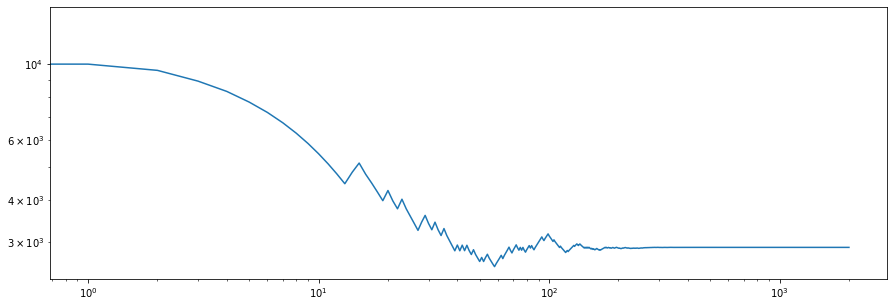

SMAPE


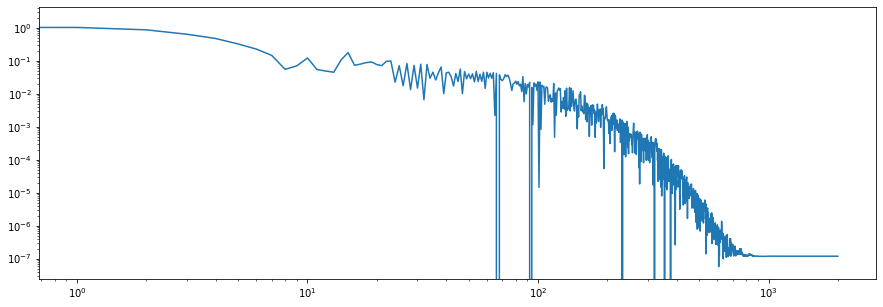

====== 0.5
MSE


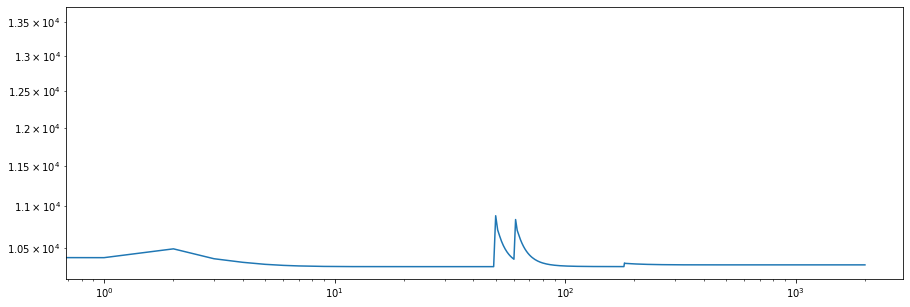

SMAPE


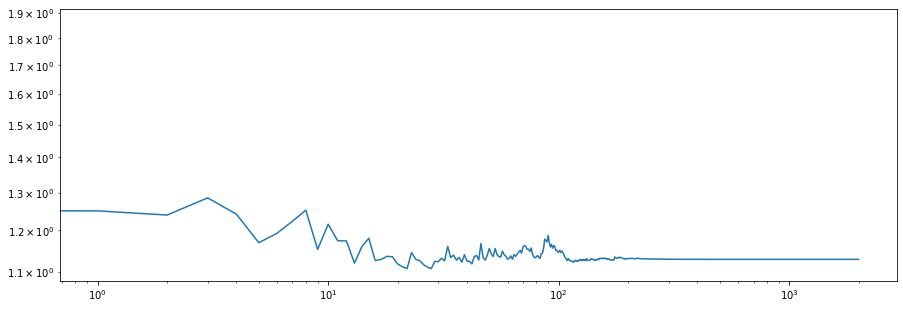

====== 1
MSE


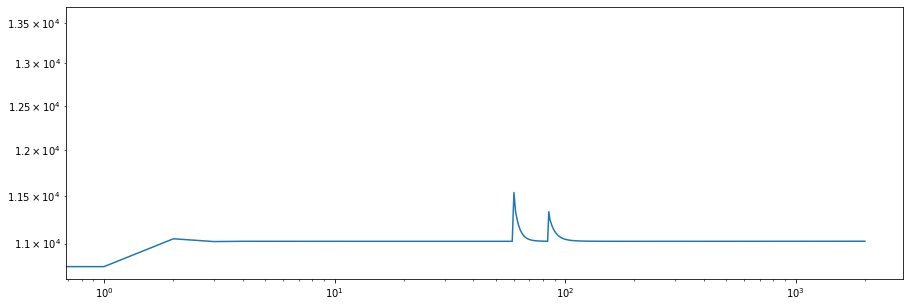

SMAPE


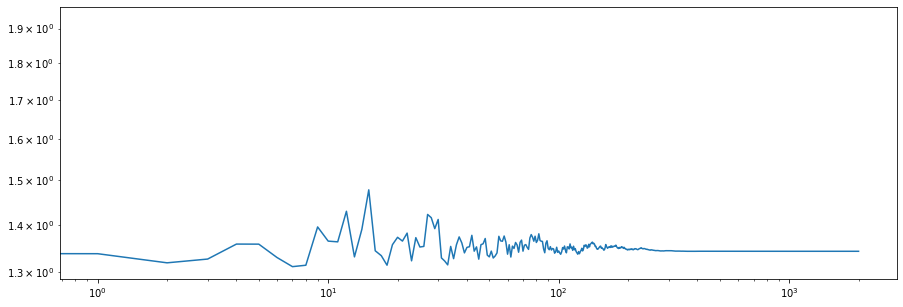

In [12]:
def dumpReg(reg):
    print('======', reg)
    gradDes(trainX, trainY, MSE, gradMSE, reg=reg, draw=True)
    gradDes(trainX, trainY, SMAPE, gradSMAPE, reg=reg, draw=True);
dumpReg(0)
dumpReg(0.5)
dumpReg(1)

smape $\frac{\|y-\hat{y}\|}{\|y\|+\|\hat{y}\|}$ при малом $\hat{y}$ дает 1 (и умножается на 2)

In [15]:
def objective_grad1(meth):
    def objective_grad(trial):
        if meth == 'MSE':
            f, g = MSE, gradMSE
        elif meth == 'SMAPE':
            f, g = SMAPE, gradSMAPE
        reg = trial.suggest_float("reg", 0, 5)
        if reg == 0:
            print("@@@@@@ reg was 0")
        step = trial.suggest_float("step", 0, 10)
        st = trial.suggest_float("st", 0, 1)
        res = gradDes(trainX, trainY, f, g, reg=reg, step=step, st=st, draw=False)
        trial.set_user_attr('p', res)
        return f(trainX, trainY, res, reg)
    study_grad = optuna.create_study()
    study_grad.optimize(objective_grad, n_trials=100)
    print(meth)
    print("Best value: {} (params: {})\n".format(study_grad.best_value, study_grad.best_params))
    return study_grad
msePar = objective_grad1('MSE')
smapePar = objective_grad1('SMAPE')
print('least2')
print("Best value: {} (params: {})\n".format(study_least2.best_value, study_least2.best_params))

MSE
Best value: 1048.5485775157117 (params: {'reg': 1.138749710797356, 'step': 6.794553018111606, 'st': 0.11346977083835669})

SMAPE
Best value: 0.012406672309706723 (params: {'reg': 0.006542527068119877, 'step': 2.6835997828457843, 'st': 0.9560325359320017})

least2
Best value: 0.011620595375040123 (params: {'reg': 0.006192708906761116})



In [16]:
def checkWith(f):
    print('======== ', f.__name__)
    print('grad smape')
    print(f(testX, testY, smapePar.best_trial.user_attrs['p'], smapePar.best_trial.params['reg']))
    print('grad mse')
    print(f(testX, testY, msePar.best_trial.user_attrs['p'], msePar.best_trial.params['reg']))
    print('least2')
    print(f(testX, testY, study_least2.best_trial.user_attrs['p'], study_least2.best_trial.params['reg']))
checkWith(SMAPE)
checkWith(NRMSE)
checkWith(MSE)

========  SMAPE
grad smape
0.01309230891546463
grad mse
15.382306339049599
least2
0.012306335378799356
========  NRMSE
grad smape
0.0012294425933894904
grad mse
0.28974599283137265
least2
0.001201662282948157
========  MSE
grad smape
0.017587138549667713
grad mse
976.8177706310993
least2
0.016801325088541867


Метод наименьших квадратов лучший

Однако, если на каждом спуске выбирать новую случайную стартовую точку, то спуску может, видимо, повести

In [25]:
def encapsul(meth):
    def objective_grad(trial):
        if meth == 'MSE':
            f, g = MSE, gradMSE
        elif meth == 'SMAPE':
            f, g = SMAPE, gradSMAPE
        reg = trial.suggest_float("reg", 0, 5)
        if reg == 0:
            print("@@@@@@ reg was 0")
        step = trial.suggest_float("step", 0, 10)
        st = trial.suggest_float("st", 0, 1)
        res = gradDes(trainX, trainY, f, g, reg=reg, step=step, st=st, draw=False, start=mkStart())
        trial.set_user_attr('p', res)
        return f(trainX, trainY, res, reg)
    study_grad = optuna.create_study()
    study_grad.optimize(objective_grad, n_trials=300)
    print(meth)
    print("Best value: {} (params: {})\n".format(study_grad.best_value, study_grad.best_params))
encapsul('SMAPE')

SMAPE
Best value: 1.4334578041777638e-05 (params: {'reg': 7.445885852167466e-06, 'step': 1.0236467520007908, 'st': 0.9682727823264333})

